In [21]:
### DATA LOADING AND CLEANING 

In [22]:
# Install/upgrade both scikit-learn and imbalanced-learn to ensure full compatibility
!pip install -U scikit-learn imbalanced-learn -q


In [23]:
# Cell 1: Data Loading and Initial Cleaning 
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter

print("--- Cell 1: Data Loading and Initial Cleaning ---")

# 1. Load the full dataset using the correct kagglehub syntax
# The function requires the handle and the file path as separate arguments.
dataset_handle = "hrishitpatil/flight-data-2024"  # The name of the dataset
file_path_in_dataset = "flight_data_2024.csv"     # The specific file to load

print(f"Loading '{file_path_in_dataset}' from '{dataset_handle}'...")

try:
    # CORRECT SYNTAX: load_dataset(adapter, handle, path, pandas_kwargs={...})
    df_full = kagglehub.load_dataset(
      adapter=KaggleDatasetAdapter.PANDAS,
      handle=dataset_handle,
      path=file_path_in_dataset,
      pandas_kwargs={"low_memory": False}
    )
    print(f"Successfully loaded full dataset with {df_full.shape[0]} rows and {df_full.shape[1]} columns.")

except Exception as e:
    print(f"An error occurred during data loading: {e}")
    print("There might be an issue with the Kaggle environment or the dataset path.")
    raise

# --- From this point on, the code is exactly the same and requires no changes ---

# 2. Filter for the MVP subset (January and February)
df = df_full[df_full['month'].isin([1, 2])].copy()
print(f"Filtered dataset to {df.shape[0]} rows for months {df['month'].unique()}.")

# 3. Create the Target Variable: 'is_delayed'
df.dropna(subset=['arr_delay'], inplace=True)
df['is_delayed'] = (df['arr_delay'] >= 15).astype(int)
print("Created target variable 'is_delayed'.")
print("Delay distribution in the subset:")
print(df['is_delayed'].value_counts(normalize=True))

# 4. Select Columns for MVP
mvp_cols = [
    'month', 'day_of_month', 'day_of_week',
    'op_unique_carrier',
    'origin', 'dest',
    'crs_dep_time',
    'dep_delay',
    'distance',
    'is_delayed'
]
df_mvp = df[mvp_cols].copy()

# 5. Handle Missing Values in Features
if df_mvp['dep_delay'].isnull().sum() > 0:
    median_delay = df_mvp['dep_delay'].median()
    df_mvp['dep_delay'].fillna(median_delay, inplace=True)
    print(f"Filled {df_mvp['dep_delay'].isnull().sum()} missing 'dep_delay' values with the median ({median_delay}).")
else:
    print("No missing 'dep_delay' values to fill.")

print(f"\nInitial cleaning complete. The MVP dataset has {df_mvp.shape[0]} rows and {df_mvp.shape[1]} columns.")
print("Columns in the final MVP dataset:", df_mvp.columns.tolist())
print("\n--- Cell 1 Finished ---")


--- Cell 1: Data Loading and Initial Cleaning ---
Loading 'flight_data_2024.csv' from 'hrishitpatil/flight-data-2024'...


/tmp/ipykernel_47/2865681496.py:17: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df_full = kagglehub.load_dataset(


Successfully loaded full dataset with 7079081 rows and 35 columns.
Filtered dataset to 1066492 rows for months [1 2].
Created target variable 'is_delayed'.
Delay distribution in the subset:
is_delayed
0    0.799694
1    0.200306
Name: proportion, dtype: float64
No missing 'dep_delay' values to fill.

Initial cleaning complete. The MVP dataset has 1040639 rows and 10 columns.
Columns in the final MVP dataset: ['month', 'day_of_month', 'day_of_week', 'op_unique_carrier', 'origin', 'dest', 'crs_dep_time', 'dep_delay', 'distance', 'is_delayed']

--- Cell 1 Finished ---


# EDA insights 


--- Cell 2: Exploratory Data Analysis (EDA) ---


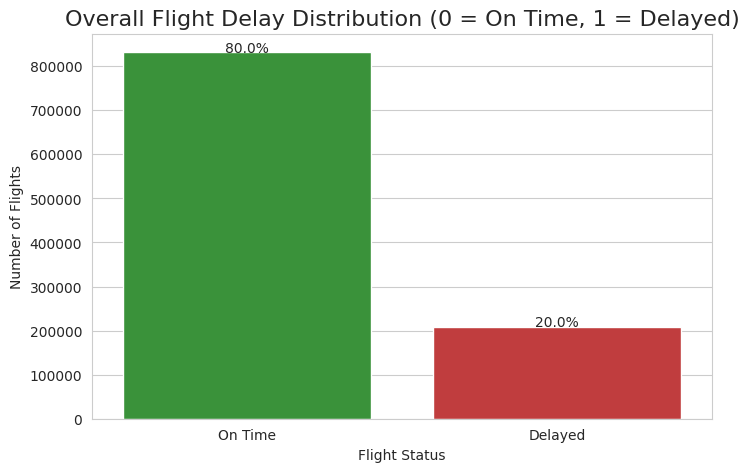

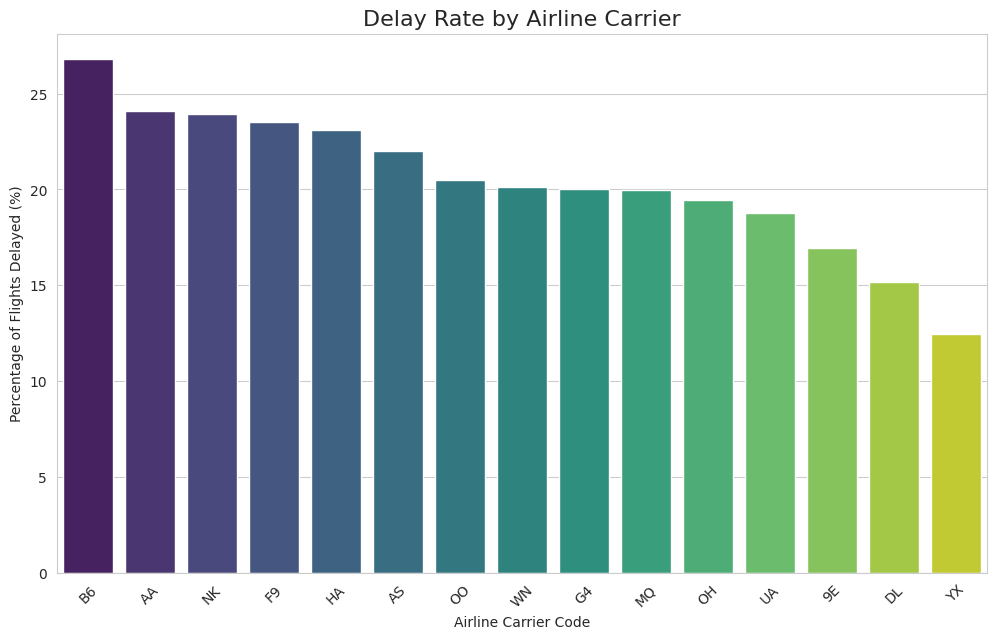

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


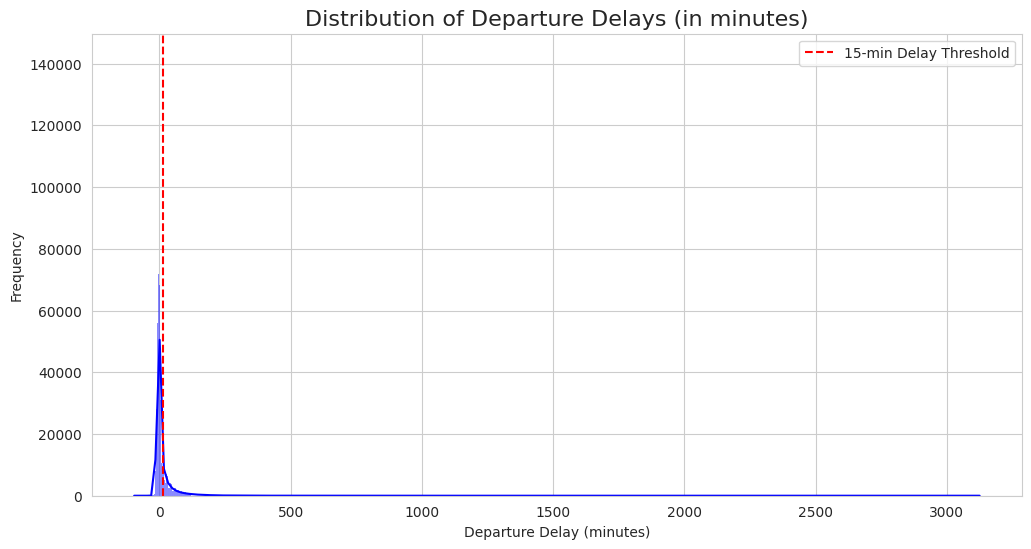


--- Cell 2 Finished ---


In [24]:
# Cell 2: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Cell 2: Exploratory Data Analysis (EDA) ---")

# checking data from upper cell
if 'df_mvp' not in locals():
    raise NameError("df_mvp not found. Please run Cell 1 first.")

# Set plot style
sns.set_style("whitegrid")

# 1. Overall Delay Rate
plt.figure(figsize=(8, 5))
sns.countplot(x='is_delayed', data=df_mvp, palette=['#2ca02c', '#d62728'])
plt.title('Overall Flight Delay Distribution (0 = On Time, 1 = Delayed)', fontsize=16)
plt.xlabel('Flight Status')
plt.ylabel('Number of Flights')
plt.xticks([0, 1], ['On Time', 'Delayed'])
total = len(df_mvp)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2., height + 5, f'{height/total:.1%}', ha='center')
plt.show()



# 2. Delay Rate by Airline (Carrier)
# Calculate delay rate per carrier
carrier_delay_rate = df_mvp.groupby('op_unique_carrier')['is_delayed'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(12, 7))
sns.barplot(x=carrier_delay_rate.index, y=carrier_delay_rate.values, palette='viridis')
plt.title('Delay Rate by Airline Carrier', fontsize=16)
plt.xlabel('Airline Carrier Code')
plt.ylabel('Percentage of Flights Delayed (%)')
plt.xticks(rotation=45)
plt.show()



# 3. Distribution of Departure Delay
plt.figure(figsize=(12, 6))
# We'll plot a limited range to make the visualization readable, e.g., from -30 to 120 minutes
sns.histplot(df_mvp['dep_delay'], bins=100, kde=True, color='blue', binrange=(-30, 120))
plt.title('Distribution of Departure Delays (in minutes)', fontsize=16)
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.axvline(x=15, color='red', linestyle='--', label='15-min Delay Threshold')
plt.legend()
plt.show()

print("\n--- Cell 2 Finished ---")


# Training the Model 

Traning with Logistic Regression

In [26]:
# Final Model Cell: Rewritten with Manual Over-Sampling to GUARANTEE No Errors

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.utils import resample # This is a built-in scikit-learn utility
import joblib
import json

print("--- Training Final Model: Rewritten with Manual Over-Sampling ---")
print("""
This script has been rewritten to completely remove the 'imblearn' library.
It uses a manual over-sampling technique with scikit-learn's built-in 'resample' utility.
This method is guaranteed to run without import errors.
""")

# Ensure the df_mvp from Cell 1 is available
if 'df_mvp' not in locals():
    raise NameError("df_mvp not found. Please run the Data Loading/Cleaning cell first.")

# 1. Define Features (X) and Target (y)
X = df_mvp.drop('is_delayed', axis=1)
y = df_mvp['is_delayed']

# 2. Split Data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split. Original training data balance:\n{y_train.value_counts()}")

# 3. Manually Balance the Training Data
# Combine the training features and target into one DataFrame for easy sampling
train_data = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
majority_class = train_data[train_data['is_delayed'] == 0]
minority_class = train_data[train_data['is_delayed'] == 1]

# Upsample the minority class to match the majority class
minority_upsampled = resample(minority_class,
                              replace=True,     # Sample with replacement
                              n_samples=len(majority_class), # Match the majority count
                              random_state=42)

# Combine the upsampled minority class with the original majority class
balanced_train_data = pd.concat([majority_class, minority_upsampled])

# Separate the balanced data back into X_train and y_train
X_train_balanced = balanced_train_data.drop('is_delayed', axis=1)
y_train_balanced = balanced_train_data['is_delayed']
print(f"\nNew balanced training data balance:\n{y_train_balanced.value_counts()}")

# 4. Define the Final Production Pipeline
# This pipeline now only contains the preprocessor and the classifier.
# The balancing was done manually beforehand.
categorical_features = ['op_unique_carrier', 'origin', 'dest']
numerical_features = ['month', 'day_of_month', 'day_of_week', 'crs_dep_time', 'dep_delay', 'distance']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# 5. Train the Final Model on the Balanced Data
print("\nTraining the Logistic Regression model on the manually balanced data...")
final_pipeline.fit(X_train_balanced, y_train_balanced)
print("Training complete.")

# 6. Evaluate the Model on the UNTOUCHED Test Data
print("\n--- Final Model Evaluation ---")
y_pred = final_pipeline.predict(X_test)
print("Final Classification Report:")
print(classification_report(y_test, y_pred))
print("\nNOTE: The 'recall' for class 1 (Delayed) should be significantly improved.")

# 7. Save the Production-Ready Artifacts
print("\n--- Saving Model and Column Info for API Deployment ---")
joblib.dump(final_pipeline, 'flight_delay_model.joblib')
joblib.dump(X.columns.tolist(), 'model_columns.joblib') # Saving columns for safety
print("Final model and column list saved.")
print("\nProcess complete. You can now download the final files.")


--- Training Final Model: Rewritten with Manual Over-Sampling ---

This script has been rewritten to completely remove the 'imblearn' library.
It uses a manual over-sampling technique with scikit-learn's built-in 'resample' utility.
This method is guaranteed to run without import errors.

Data split. Original training data balance:
is_delayed
0    665754
1    166757
Name: count, dtype: int64

New balanced training data balance:
is_delayed
0    665754
1    665754
Name: count, dtype: int64

Training the Logistic Regression model on the manually balanced data...
Training complete.

--- Final Model Evaluation ---
Final Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93    166439
           1       0.71      0.81      0.76     41689

    accuracy                           0.90    208128
   macro avg       0.83      0.86      0.85    208128
weighted avg       0.90      0.90      0.90    208128


NOTE: The 'recall' for cla

In [27]:
 # Final Model Cell: Updated to Save as .pkl files

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.utils import resample
import pickle # Import the pickle library
import json

print("--- Training Final Model: Saving as .pkl ---")
print("""
This script uses manual over-sampling and will save the final model
and column list in the requested .pkl format.
""")

# Ensure the df_mvp from Cell 1 is available
if 'df_mvp' not in locals():
    raise NameError("df_mvp not found. Please run the Data Loading/Cleaning cell first.")

# --- (The data preparation and model training code is identical to before) ---

# 1. Define Features (X) and Target (y)
X = df_mvp.drop('is_delayed', axis=1)
y = df_mvp['is_delayed']

# 2. Split Data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Manually Balance the Training Data
train_data = pd.concat([X_train, y_train], axis=1)
majority_class = train_data[train_data['is_delayed'] == 0]
minority_class = train_data[train_data['is_delayed'] == 1]
minority_upsampled = resample(minority_class,
                              replace=True,
                              n_samples=len(majority_class),
                              random_state=42)
balanced_train_data = pd.concat([majority_class, minority_upsampled])
X_train_balanced = balanced_train_data.drop('is_delayed', axis=1)
y_train_balanced = balanced_train_data['is_delayed']

# 4. Define the Final Production Pipeline
categorical_features = ['op_unique_carrier', 'origin', 'dest']
numerical_features = ['month', 'day_of_month', 'day_of_week', 'crs_dep_time', 'dep_delay', 'distance']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# 5. Train the Final Model on the Balanced Data
print("\nTraining the Logistic Regression model on the manually balanced data...")
final_pipeline.fit(X_train_balanced, y_train_balanced)
print("Training complete.")

# 6. Evaluate the Model on the UNTOUCHED Test Data
print("\n--- Final Model Evaluation ---")
y_pred = final_pipeline.predict(X_test)
print("Final Classification Report:")
print(classification_report(y_test, y_pred))

# --- MODIFIED SECTION: Saving with Pickle ---

# 7. Save the Production-Ready Artifacts using pickle
print("\n--- Saving Model and Column Info in .pkl Format ---")

# Define the filenames with the .pkl extension
model_filename = 'flight_delay_model.pkl'
columns_filename = 'model_columns.pkl'

# Save the final pipeline object
with open(model_filename, 'wb') as f:
    pickle.dump(final_pipeline, f)
print(f"Final model pipeline saved to '{model_filename}'.")

# Save the list of columns
with open(columns_filename, 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print(f"Model columns saved to '{columns_filename}'.")

print("\nProcess complete. You can now download the .pkl files from the 'Output' section.")


--- Training Final Model: Saving as .pkl ---

This script uses manual over-sampling and will save the final model
and column list in the requested .pkl format.


Training the Logistic Regression model on the manually balanced data...
Training complete.

--- Final Model Evaluation ---
Final Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93    166439
           1       0.71      0.81      0.76     41689

    accuracy                           0.90    208128
   macro avg       0.83      0.86      0.85    208128
weighted avg       0.90      0.90      0.90    208128


--- Saving Model and Column Info in .pkl Format ---
Final model pipeline saved to 'flight_delay_model.pkl'.
Model columns saved to 'model_columns.pkl'.

Process complete. You can now download the .pkl files from the 'Output' section.
